In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import autoencoder.helpers as helpers
from autoencoder.neuralnet import NeuralNetwork
from autoencoder.layers import (
  LinearLayer,
  SigmoidLayer,
  TanhLayer,
  ReluLayer,
  MSEOutputLayer
)

import tikhonov
from utils import avgn_attack
from utils import ssim

In [2]:
shape=(28, 28)

In [33]:
def compare_denoised_images(images_true, images_noisy, denoised_samples, num_samples=8, idx=0, shape=(28, 28)):
  images_true_ = images_true[idx:idx+num_samples]
  images_noisy_ = images_noisy[idx:idx+num_samples]
  denoised_samples_ =  denoised_samples[idx:idx+num_samples]
  fig, axs = plt.subplots(3, num_samples, figsize=(30, 10))
  axs_ = axs.ravel()

  for i, (ts, ns, ds) in enumerate(zip(images_true_, images_noisy_, denoised_samples_)):
    axs_[i].axis('off')
    axs_[i].imshow(ts.reshape(shape), cmap="gray")
    axs_[(num_samples) + i].imshow(ns.reshape(shape), cmap="gray")
    axs_[(2 * num_samples) + i].imshow(ds.reshape(shape), cmap="gray")

In [89]:
def compare_tikhonov_autoencoder_ssim(clean_images, noisy_images, tikhonov_images, autoencoder_images, idx=0, figsize=(12, 12), shape=(28, 28)):
  (clean_image, noisy_image, tikhonov_image, autoencoder_image) = \
    (clean_images[idx].reshape(shape),
     noisy_images[idx].reshape(shape),
     tikhonov_images[idx].reshape(shape),
     autoencoder_images[idx].reshape(shape))
 
  print(autoencoder_image.shape)
  fig, axs = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'hspace': 0.15, 'wspace': -0.125})
  axs_ = axs.ravel()
  print(noisy_image.shape)
  imgs_info = [
    {'name': 'Чисте зображення', 'img': clean_image, 'ssim': ssim(clean_image, clean_image)},
    {'name': 'Пошкоджене зображення', 'img': noisy_image, 'ssim': ssim(clean_image, noisy_image)},
    {'name': 'Регуляризація Тіхонова', 'img': tikhonov_image, 'ssim': ssim(clean_image, tikhonov_image)},
    {'name': 'Автоенкодер', 'img': autoencoder_image, 'ssim': ssim(clean_image, autoencoder_image)},
  ]

  for ax, img_info in zip(axs_, imgs_info):
    ax.imshow(img_info['img'], 'gray')
    ax.axis('off')
    ax.set_title(f"{img_info['name']}\n SSIM: {np.round(img_info['ssim'], 3)}", fontsize=15)
  
  fig.savefig('images/denoising_methods_comparation.pdf')


In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(-1, 28*28) / 255
X_test = X_test.reshape(-1, 28*28) / 255

In [17]:
X_train_noisy = np.array([avgn_attack(x, 0.5, 0) for x in X_train])
X_test_noisy = np.array([avgn_attack(x, 0.5, 0) for x in X_test])

In [8]:
import keras
from keras import layers
from keras.datasets import mnist as mnist

In [3]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [4]:
from keras import backend as K


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


In [5]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [6]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [17]:
# x_train.shape

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 220.6165 - val_loss: 169.1591
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 168.4603 - val_loss: 165.1276
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 164.2900 - val_loss: 162.1634
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 161.5530 - val_loss: 159.7805
Epoch 5/100
1875/1875 [==============================] - 3s 2ms/step - loss: 158.9009 - val_loss: 158.0244
Epoch 6/100
1875/1875 [==============================] - 3s 2ms/step - loss: 157.3290 - val_loss: 156.1754
Epoch 7/100
1875/1875 [==============================] - 3s 2ms/step - loss: 155.3043 - val_loss: 155.2052
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 154.4219 - val_loss: 154.2705
Epoch 9/100
1875/1875 [==============================] - 3s 2ms/step - loss: 153.7571 - val_loss: 153.7020
Epoch 10/100
1875/1875 [=============

In [20]:
x_test_encoded = encoder.predict(x_test, batch_size=32)
print(np.array(x_test_encoded).shape)
# plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
# plt.colorbar()
# plt.show()

(3, 10000, 2)


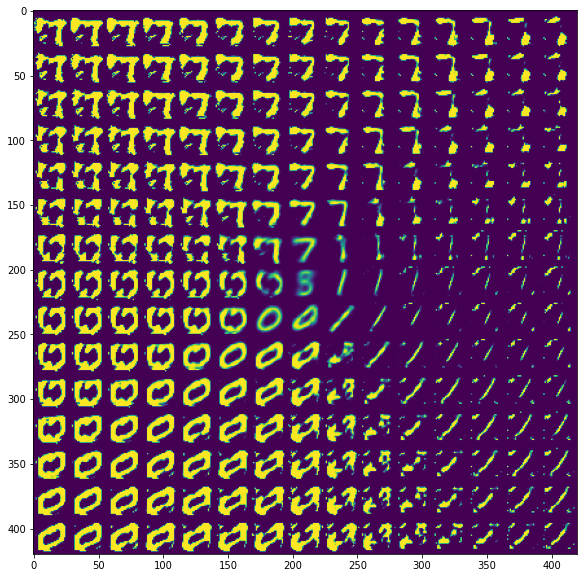

In [15]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [21]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

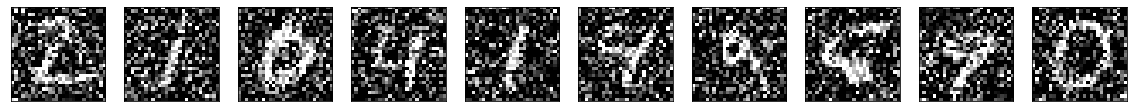

In [22]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [23]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [25]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 72s 153ms/step - loss: 0.2547 - val_loss: 0.1183
Epoch 2/100
469/469 [==============================] - 88s 188ms/step - loss: 0.1163 - val_loss: 0.1086
Epoch 3/100
469/469 [==============================] - 74s 158ms/step - loss: 0.1087 - val_loss: 0.1048
Epoch 4/100
469/469 [==============================] - 74s 157ms/step - loss: 0.1052 - val_loss: 0.1026
Epoch 5/100
469/469 [==============================] - 61s 131ms/step - loss: 0.1035 - val_loss: 0.1015
Epoch 6/100
469/469 [==============================] - 63s 134ms/step - loss: 0.1018 - val_loss: 0.1000
Epoch 7/100
469/469 [==============================] - 67s 142ms/step - loss: 0.1009 - val_loss: 0.0993
Epoch 8/100
469/469 [==============================] - 66s 142ms/step - loss: 0.0999 - val_loss: 0.0986
Epoch 9/100
469/469 [==============================] - 66s 141ms/step - loss: 0.0992 - val_loss: 0.0981
Epoch 10/100
469/469 [==============================] - 71s 152m

In [31]:
x_test_encoded = autoencoder.predict(x_test, batch_size=32).reshape(-1, 28, 28)

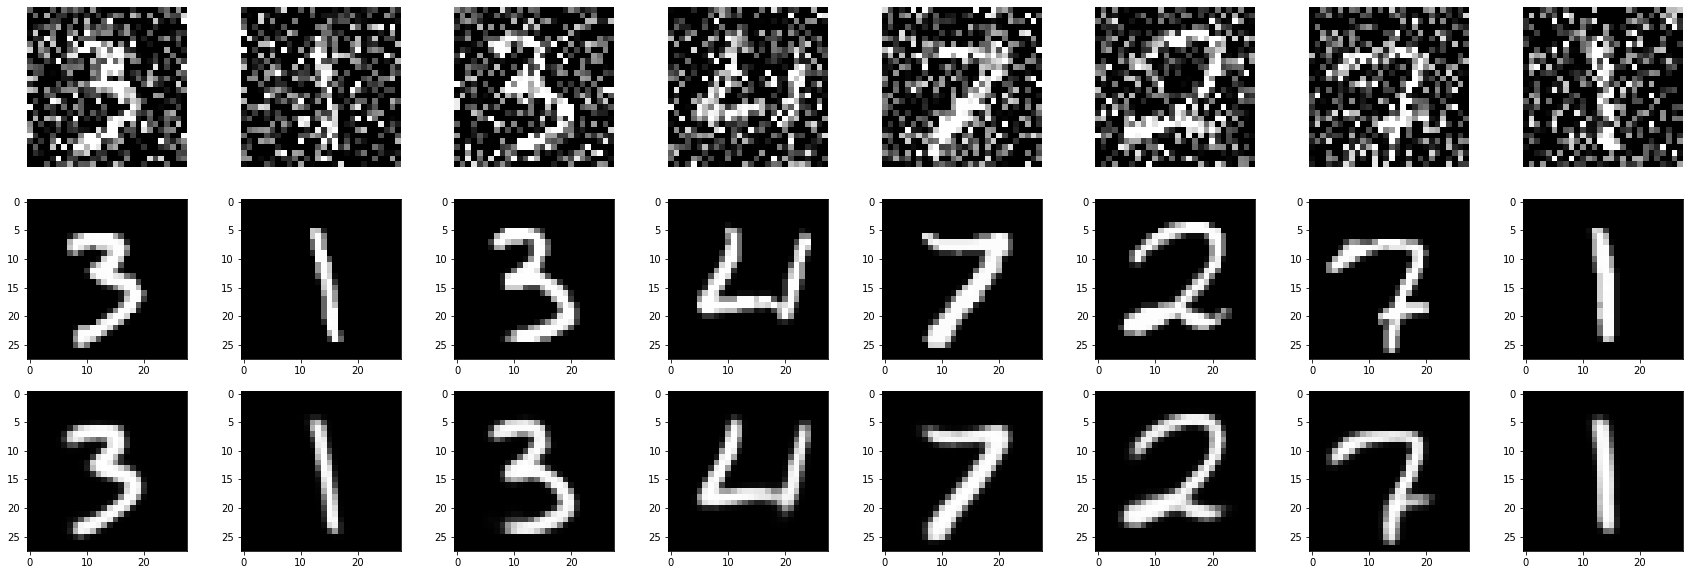

In [35]:
compare_denoised_images(x_test_noisy.reshape(-1, 28, 28), x_test.reshape(-1, 28, 28), x_test_encoded.reshape(-1, 28, 28), idx=30)
# print(np.array(x_test_encoded).shape)

(28, 28)
(28, 28)


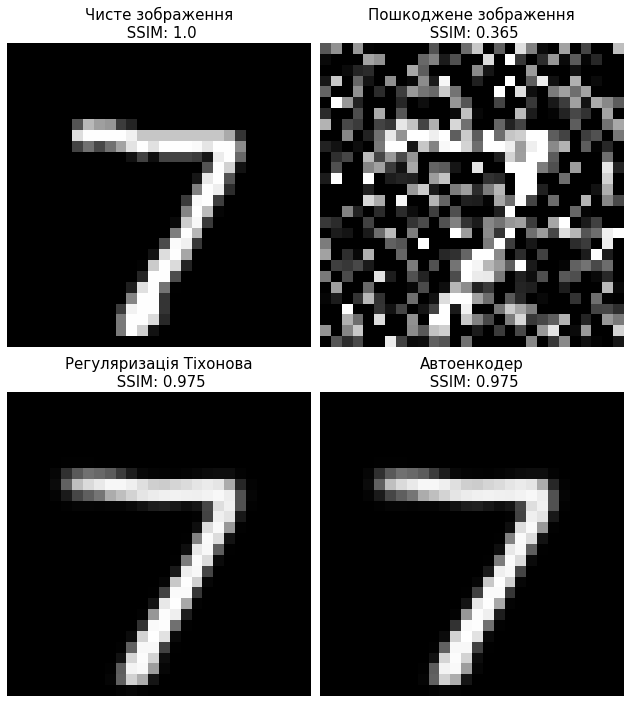

In [91]:
compare_tikhonov_autoencoder_ssim(
  x_test.reshape(-1, 28*28),
  x_test_noisy.astype('float32').reshape(-1, 28*28),
  x_test_encoded.reshape(-1, 28*28), 
  x_test_encoded.reshape(-1, 28*28)
)

In [ ]:
x_test_encoded.reshape(-1, 28, 28),

In [42]:
compare_denoised_images(x_test_noisy.reshape(-1, 28, 28), x_test.reshape(-1, 28, 28), x_test_encoded.reshape(-1, 28, 28), x_test_encoded.reshape(-1, 28, 28))

TypeError: only integer scalar arrays can be converted to a scalar index

In [44]:
# fig, axs_costs = plt.subplots(1, 4, figsize=(15, 5))
# axs_costs_ = axs_costs.ravel()
# for i, costs in enumerate(
#   [net.train_costs, net.val_costs, net.batch_costs, net.ssim_costs]):
#   axs_costs_[i].plot(costs)

In [128]:
# """
# [0.08796975330682472, 0.16110488993488253, 0.19499662654288114, 0.21184221137687564, 0.2271088240072131, 0.24005389137566088, 0.25066351728141306, 0.25958357924222947, 0.26742243687808515, 0.2751030956953764, 0.2824278920143843, 0.2889249113574624, 0.2944175705835223, 0.29872014674544334, 0.3022242000848055, 0.30530017347633837, 0.3081676989644766, 0.3110213182941079, 0.3137230723127723, 0.3163199815154076, 0.3189624789506197, 0.3215894022732973, 0.3240816998630762, 0.3263583050444722, 0.3282782381623983, 0.3300696391314268, 0.3316933545097709, 0.3332481457144022, 0.3347417757064104, 0.33591546276956796]]
# """
# indecies = np.arange(0, len(net.ssim_costs), 2).tolist()
# costs = np.array(net.ssim_costs)[indecies]

# fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlabel('Epoch iteration', fontsize=20)
# ax.set_ylabel('SSIM score', fontsize=20)
# plt.grid(linestyle='--')


# plt.plot(indecies, costs, "go-", label='SSIM')
# legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
# fig.savefig("training-ssim.pdf")

In [129]:
# """
# [0.12831482432154193, 0.126240757987006, 0.12450315573643643, 0.12348159149266774, 0.12247684903903182, 0.12165188051810928, 0.12089223815858824, 0.12029861078602709, 0.11979477504238446, 0.1193165323235328, 0.1188621116171617, 0.11847048050350964, 0.11816420827665707, 0.11791130814766183, 0.11768721189304704, 0.11746880801063622, 0.11726081182734108, 0.11704540420684759, 0.11683771806818084, 0.11663801546512795, 0.11644320224931556, 0.11626320524015603, 0.1160999364894973, 0.1159667496161961, 0.11586285096179647, 0.11577296145565284, 0.11569176091782649, 0.11562160879286928, 0.11556917920009573, 0.11551754115893434]
# """
# indecies = np.arange(0, len(net.val_costs), 2).tolist()
# costs = np.array(net.val_costs)[indecies]

# fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlabel('Epoch iteration', fontsize=20)
# ax.set_ylabel('MSE score', fontsize=20)
# plt.grid(linestyle='--')
# plt.plot(indecies, costs, "go-", label='SSIM')
# legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
# fig.savefig("training-mse.pdf")

In [112]:
prefix = "denoising-avgn-05-relu-relu-sigmoid-30-iter-128-batch"
#best - prefix = "denoising-avgn-05-relu-relu-sigmoid-30-iter-128-batch"

In [113]:
# helpers.save_model(net_layers, prefix=prefix)

In [114]:
new_layers = helpers.load_model(prefix)

In [115]:
new_net = NeuralNetwork()
new_net.load_layers(new_layers)

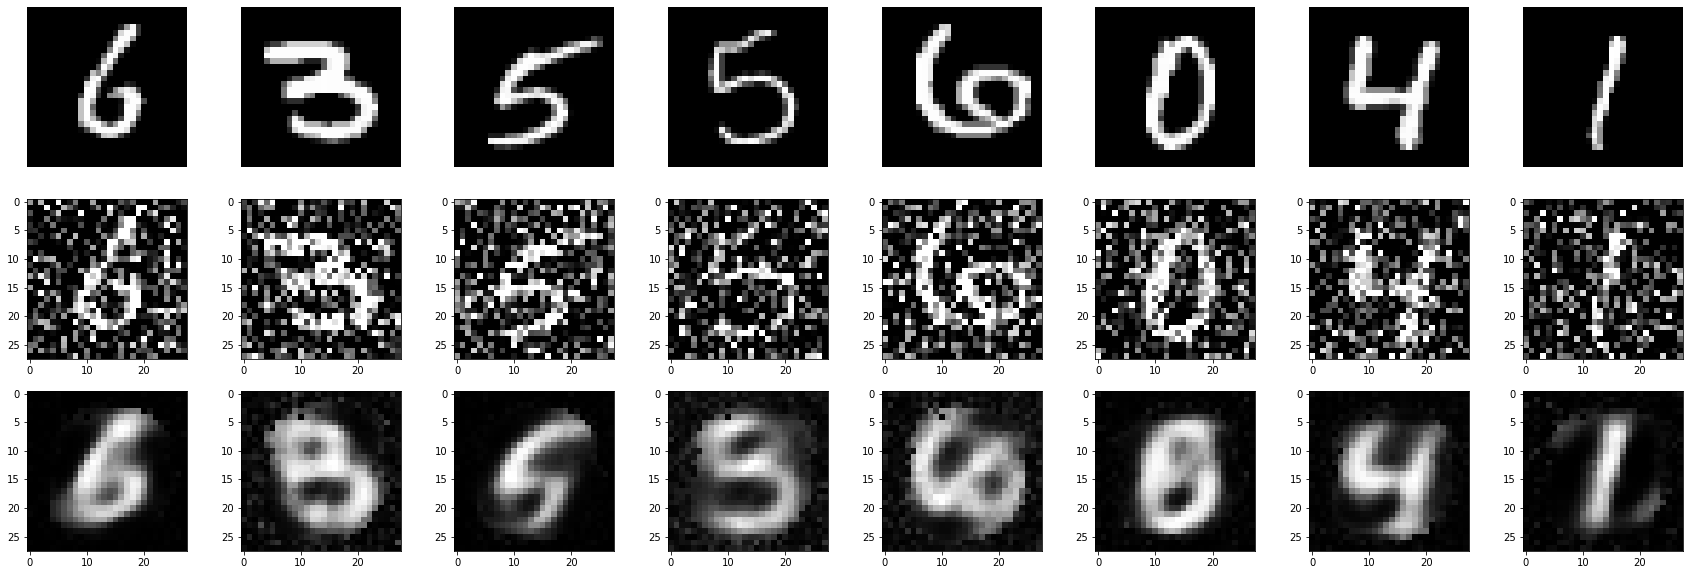

In [118]:
X_test_denoised_autoencoder = new_net.forward_step(X_test_noisy)[-1]
compare_denoised_images(X_test, X_test_noisy, X_test_denoised_autoencoder, idx=50)